# Hold-out Method

In questo script, i dati vengono suddivisi in due set principali:

- **Training set (80%)**
- **Test set (20%)**

Successivamente, il **Training set** viene ulteriormente suddiviso in due parti:

- **Train set (80%)**
- **Validation set (20%)**

Questa suddivisione permette di allenare il modello sui dati di training, validarlo durante l'allenamento tramite il validation set, e infine testarlo sui dati separati del test set.

Le performance dei modelli vengono misurate su diverse combinazioni di **features** calcolate nello script *BENEDETTO_HW3_ES1_A*, per confrontare l'efficacia delle varie configurazioni nel predire il target.


## Importazione librerie

In [1]:
# Importazione delle librerie necessarie
import warnings
warnings.filterwarnings("ignore")  # Disattivazione di tutti gli avvisi (WARNING)

# Librerie principali per la gestione dei dati e la visualizzazione
import numpy as np                  
import pandas as pd                 
import matplotlib.pyplot as plt    
import seaborn as sns    
import itertools           

# Librerie per preprocessing, modellazione e metriche
from sklearn.preprocessing import StandardScaler  
from sklearn.utils import class_weight          
from sklearn.decomposition import PCA            
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn import metrics                     
from sklearn.metrics import (confusion_matrix,  
                             f1_score)          

# Impostazione dei colori per i grafici utilizzando la colormap "viridis"
colors = plt.cm.viridis([0.1, 0.3, 0.5, 0.7, 0.9])  # 5 colori diversi (5 classi) equidistanti

## Caricamento Dataframes

In [2]:
# Caricamento dei file CSV contenenti le caratteristiche calcolate
statistical_df = pd.read_csv("statistical_features.csv")  
texture_df = pd.read_csv("texture_features.csv")          
edge_df = pd.read_csv("edge_features.csv")                
physiological_df = pd.read_csv("physiological_features.csv")  

# Merge dei DataFrame
# Concatenazione dei DataFrame lungo l'asse delle colonne (axis=1)
# Viene mantenuta una sola colonna "label"
all_df = pd.concat([statistical_df, texture_df, edge_df, physiological_df], axis=1)

# Rimozione delle colonne duplicate (più colonne "label")
all_df = all_df.loc[:, ~all_df.columns.duplicated()]  # Selezione solo delle colonne univoche

## Prima Riduzione delle Feature

Come anticipato nel **script "BENEDETTO_HW3_ES_1A.ipynb"**, delle 16 **patch** per ogni immagine, solo 6 sono significative per la classificazione. Queste patch coprono lo spazio tra tibia e perone, che è la regione di interesse per l'analisi osteoartritica. Le patch selezionate sono le seguenti:

- Patch 5, 6, 8, 9, 10, 11.

Pertanto, i modelli verranno addestrati e validati utilizzando diverse configurazioni di **feature**:

1. **Tutte le feature insieme:** tutte le tipologie di feature (physiological, texture, edge, e statistical) verranno combinate per formare un dataset completo.
   
2. **Feature per tipologia:** i modelli saranno addestrati separatamente per ciascuna tipologia di feature:
   - **Statistical Features**
   - **Physiological Features**
   - **Edge Features**
   - **Texture Features**

3. **Riduzione delle feature (Patch selezionate):** verranno selezionate solo le 6 patch significative per la classificazione, riducendo quindi la dimensione del dataset e focalizzandosi esclusivamente sulla regione di interesse.

Questa fase di riduzione delle feature permetterà di eseguire un'analisi mirata e di testare come la selezione delle patch e l'uso di specifiche tipologie di feature influenzano le prestazioni del modello.

### Numero di Feature per Ogni DataFrame:

- **Statistical Features:** 64 (16 patch * 4 feature per patch)
- **Texture Features:** 224 (16 patch * 14 feature per patch)
- **Edge Features:** 32 (16 patch * 2 feature per patch)
- **Physiological Features:** 7 
- **All Features:** 327 (somma di tutte le feature per ogni immagine)

### Numero di Feature Ridotte per Ogni DataFrame:

- **Statistical Features Reduced:** 24 (6 patch * 4 feature per patch)
- **Texture Features Reduced:** 84 (6 patch * 14 feature per patch)
- **Edge Features Reduced:** 12 (6 patch * 2 feature per patch)
- **All Features Reduced:** 127 (somma di tutte le feature per ogni immagine con le patch selezionate + Physiological features)



In [3]:
# Eliminazione delle feature calcolate su patch che non contengono la giunzione del ginocchio.
# Si mantengono solo le feature che contengono nel nome i numeri 5, 6, 8, 9, 10, 11 e la colonna "label".

# Filtraggio delle feature rilevanti dai DataFrame
statistical_df_reduced = statistical_df.filter(regex=r'(5$|6$|8$|9$|10$|11$|label)')  
texture_df_reduced = texture_df.filter(regex=r'(5$|6$|8$|9$|10$|11$|label)')        
edge_df_reduced = edge_df.filter(regex=r'(5$|6$|8$|9$|10$|11$|label)')               

# Rimozione delle feature non necessarie (non filtrate precedentemente con la regex)
# Feature statistiche
statistical_df_reduced = statistical_df_reduced.drop(
    columns=['mean_patch_15', 'variance_patch_15', 'skewness_patch_15', 'kurtosis_patch_15']
)

# Feature texture
texture_df_reduced = texture_df_reduced.drop(
    columns=['contrast_patch_15', 'dissimilarity_patch_15', 'homogeneity_patch_15',
             'energy_patch_15', 'correlation_patch_15',
             'lbp_hist_0_patch_15', 'lbp_hist_1_patch_15', 'lbp_hist_2_patch_15',
             'lbp_hist_3_patch_15', 'lbp_hist_4_patch_15', 'lbp_hist_5_patch_15',
             'lbp_hist_6_patch_15', 'lbp_hist_7_patch_15', 'lbp_hist_8_patch_15']
)

# Feature edge
edge_df_reduced = edge_df_reduced.drop(
    columns=['mean_gradient_15', 'edge_density15']
)

# Unione dei DataFrame ridotti
# Concatenazione di tutte le feature filtrate e delle feature fisiologiche
all_df_reduced = pd.concat([statistical_df_reduced, texture_df_reduced, edge_df_reduced, physiological_df], axis=1)

# Rimozione delle colonne duplicate (più colonne "label")
all_df_reduced = all_df_reduced.loc[:, ~all_df_reduced.columns.duplicated()]  # Selezione solo delle colonne univoche

# Print del numero di feature per ogni DataFrame
print("Numero di feature per ogni DataFrame:")
print("Statistical features:", len(statistical_df.columns)-1)
print("Texture features:", len(texture_df.columns)-1)
print("Edge features:", len(edge_df.columns)-1)
print("Physiological features:", len(physiological_df.columns)-1)
print("All features:", len(all_df.columns)-1)
print("\nNumero di feature ridotte per ogni DataFrame:")
print("Statistical features reduced:", len(statistical_df_reduced.columns)-1)
print("Texture features reduced:", len(texture_df_reduced.columns)-1)
print("Edge features reduced:", len(edge_df_reduced.columns)-1)
print("All features reduced:", len(all_df_reduced.columns)-1)

Numero di feature per ogni DataFrame:
Statistical features: 64
Texture features: 224
Edge features: 32
Physiological features: 7
All features: 327

Numero di feature ridotte per ogni DataFrame:
Statistical features reduced: 24
Texture features reduced: 84
Edge features reduced: 12
All features reduced: 127


## Hold-out Method

Tutti i **dataframe** risultanti dalla fase di estrazione e riduzione delle feature sono stati divisi utilizzando il **Hold-out Method**, che separa il dataset in tre set distinti: **training set**, **validation set** e **test set**. La divisione è stata effettuata come segue:

- **Test set**: 20% dei dati, utilizzato per testare il modello.
- **Training set**: 80% dei dati iniziali, che verrà successivamente suddiviso ulteriormente in **train set** e **validation set**.
- **Validation set**: 20% del **training set**, utilizzato per la valutazione durante l'addestramento del modello.

Utilizzando il parametro stratify ho fatto si che la distribuzione delle classi rimanga invariata per ogni set.

### Standardizzazione delle Feature

La funzione di **splitting** include anche un passo di **standardizzazione** delle feature. Questo passaggio è fondamentale per garantire che tutte le variabili abbiano lo stesso peso durante l'addestramento del modello. La **standardizzazione** viene calcolata solo sul **training set**.

- La **media** e la **deviazione standard** delle feature vengono calcolate esclusivamente sul **training set**.
- Questi valori vengono poi applicati sia al **validation set** che al **test set**, per garantire coerenza nelle trasformazioni.

### Applicazione della Funzione di Splitting

La funzione di **splitting** è stata applicata a ciascun **dataframe** (completo di tutte le patch e ridotto) per ottenere i rispettivi set di **training**, **validation** e **test**. 

In [4]:
def splitting_dataframe(df, label_column='label', test_size=0.2, val_size=0.2, random_state=42):
    
    # Separazione delle feature dalle etichette
    X = df.drop(columns=[label_column])
    y = df[label_column]
    
    # Divisione in training e test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Divisione del training set in training e validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_state, stratify=y_train
    )
    
    # Standardizzazione delle feature: calcolo della media e della deviazione standard
    # solo sul training set
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  
    X_val = scaler.transform(X_val)         
    X_test = scaler.transform(X_test)        
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
# Applico la funzione di split al dataframe completo e al dataframe ridotto
X_train, X_val, X_test, y_train, y_val, y_test = splitting_dataframe(all_df)
X_train_reduced, X_val_reduced, X_test_reduced, y_train_reduced, y_val_reduced, y_test_reduced = splitting_dataframe(all_df_reduced)

# Applico la funzione di split al dataframe edge e al dataframe ridotto edge
X_train_edge, X_val_edge, X_test_edge, y_train_edge, y_val_edge, y_test_edge = splitting_dataframe(edge_df)
X_train_edge_reduced, X_val_edge_reduced, X_test_edge_reduced, y_train_edge_reduced, y_val_edge_reduced, y_test_edge_reduced = splitting_dataframe(edge_df_reduced)

# Applico la funzione di split al dataframe texture e al dataframe ridotto texture
X_train_texture, X_val_texture, X_test_texture, y_train_texture, y_val_texture, y_test_texture = splitting_dataframe(texture_df)
X_train_texture_reduced, X_val_texture_reduced, X_test_texture_reduced, y_train_texture_reduced, y_val_texture_reduced, y_test_texture_reduced = splitting_dataframe(texture_df_reduced)

# Applico la funzione di split al dataframe statistical e al dataframe ridotto statistical
X_train_statistical, X_val_statistical, X_test_statistical, y_train_statistical, y_val_statistical, y_test_statistical = splitting_dataframe(statistical_df)
X_train_statistical_reduced, X_val_statistical_reduced, X_test_statistical_reduced, y_train_statistical_reduced, y_val_statistical_reduced, y_test_statistical_reduced = splitting_dataframe(statistical_df_reduced)

# Applico la funzione di split al dataframe physiological
X_train_physiological, X_val_physiological, X_test_physiological, y_train_physiological, y_val_physiological, y_test_physiological = splitting_dataframe(physiological_df)

## Class Unbalance

Per evitare di perdere dati utili tramite **undersampling** (che ridurrebbe il numero di esempi nella classe maggioritaria) o di introdurre dati ridondanti tramite **oversampling** (che ricopia dati già presenti), o ancora di ricorrere a **data augmentation** sulla classe minoritaria (che, nel nostro caso, avrebbe compromesso la posizione critica dello spazio tra tibia e perone), si è scelto di adottare una strategia diversa.

In particolare, si è deciso di utilizzare i **class weights**, una tecnica che permette di dare maggiore importanza alle classi minoritarie durante l'addestramento del modello, senza alterare i dati originali. Questa strategia è vantaggiosa perché consente al modello di concentrarsi maggiormente sugli esempi delle classi meno rappresentate, senza perdere informazioni essenziali.

Grazie alla libreria **scikit-learn**, è possibile impostare i **class weights** come parametro per diversi modelli, come il **Support Vector Classifier (SVC)** e il **base estimator degli ensemble (ad esempio, gli alberi decisionali)**. L'inclusione dei **class weights** permette di compensare lo sbilanciamento delle classi e migliorare la capacità del modello di classificare correttamente anche le classi minoritarie.

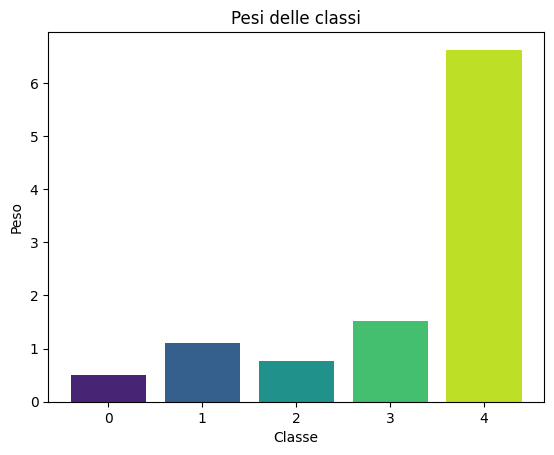

Pesi delle classi:
{0: 0.5074554294975688, 1: 1.1053839364518976, 2: 0.7594906003638568, 3: 1.5217496962332928, 4: 6.626455026455027}


In [6]:
# Calcolo dei pesi per le classi utilizzando la funzione compute_class_weight
# I pesi vengono calcolati in modo bilanciato per tener conto delle classi sbilanciate (considerando solo il training set)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),  # Classi uniche presenti nel training set
                                                  y=y_train)                   # Etichette del training set

# Converto i pesi calcolati in un dizionario che associa ogni classe al suo peso
class_weights = dict(zip(np.unique(y_train), class_weights))

# Visualizzazione dei pesi in un barplot
plt.bar(class_weights.keys(), class_weights.values(), color=colors)  
plt.xlabel('Classe')  
plt.ylabel('Peso')   
plt.title('Pesi delle classi') 
plt.show()  

# Stampa i pesi delle classi
print("Pesi delle classi:")
# Converto i valori numpy (np.float64) in float e le chiavi numpy (np.int64) in int
# Per rendere la stampa più leggibile
print({int(k): float(v) for k, v in class_weights.items()})

I class weights sono inversamente proporzionali al numero di esempi con la classe corrispondente.

## Model Fitting and Validation senza PCA

In questa fase, i diversi modelli vengono addestrati utilizzando il training set e validati tramite il set di validazione, senza l'applicazione della **Principal Component Analysis (PCA)**. La ricerca degli iperparametri ottimali avviene tramite un'analisi delle possibili combinazioni di parametri. Questo processo è realizzato con l'ausilio della funzione **hyperp_search**, che esplora vari set di iperparametri per identificare la combinazione che offre le migliori prestazioni sul set di validazione.

### Funzionamento della ricerca degli iperparametri:

1. **Combinazione di parametri:** Vengono esplorate tutte le combinazioni possibili di iperparametri forniti nel dizionario `parameters`. 
   
2. **Addestramento e predizioni:** Per ogni combinazione, il modello viene addestrato sul training set e vengono fatte le predictions  sia sul set di addestramento che su quello di validazione. Tali predizioni vengono utilizzate per calcolare le metriche di performance: **F1 score** e **accuracy**.

3. **Selezione del miglior modello:** La combinazione di iperparametr che produce il miglior **F1 score** sul set di validazione viene selezionato come la combinazione ideale. È stato scelto l'**F1 score** come metrica da massimizzare perchè racchiude sia info sulla recall che sulla precision (l'accuracy non va bene per dataset sbilanciati come questo)

4. **Riallenamento del modello:** Una volta identificati i migliori iperparametri, il modello viene ritrainato con i parametri ottimali, e il miglior modello, insieme ai parametri e alle metriche di valutazione, viene restituito.

### Risultati della valutazione:
La funzione di ricerca degli iperparametri calcola:
- **F1 score** e **accuracy** sia per il training set che per il validation set per controllare l'overfitting.
- Vengono quindi stampati i migliori parametri, le performance sul training e validation set, e il modello finale viene restituito.

In [7]:
# Funzione per la ricerca di iperparametri e valutazione utilizzando il validation set
def hyperp_search(classifier, parameters, X_train, y_train, X_val, y_val):
    results = []  # Lista per memorizzare i risultati di tutte le combinazioni di parametri
    
    # Iterazione manuale sui parametri da esplorare tramite il prodotto cartesiano
    for param_comb in (dict(zip(parameters, x)) for x in itertools.product(*parameters.values())):
        # Imposta i parametri del classificatore
        classifier.set_params(**param_comb)
        
        # Allena il modello sul training set
        classifier.fit(X_train, y_train)
        
        # Predizioni sui dataset di validation e training
        y_pred_val = classifier.predict(X_val)
        y_pred_train = classifier.predict(X_train)
        
        # Calcola le metriche di valutazione per il training e il validation set
        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        f1_val = f1_score(y_val, y_pred_val, average='weighted')
        accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
        accuracy_val = metrics.accuracy_score(y_val, y_pred_val)
        
        # Memorizza i risultati per ogni combinazione di parametri
        results.append((param_comb, f1_train, f1_val, accuracy_train, accuracy_val))
    
    # Seleziona i migliori parametri in base al miglior F1 score sul validation set
    best_result = max(results, key=lambda x: x[2])  # Massimizza l'F1 score sulla validazione
    best_params = best_result[0]  # I migliori parametri
    
    # Stampa i risultati
    print(f"{'-'*40}")
    print(f"Classificatore: {classifier}")
    print(f"Migliori Parametri: {best_params}")
    print(f"{'-'*40}")
    print(f"F1 Score (Train): {best_result[1]:.3f}")
    print(f"F1 Score (Validation): {best_result[2]:.3f}")
    print(f"Accuracy (Train): {best_result[3]:.3f}")
    print(f"Accuracy (Validation): {best_result[4]:.3f}")
    print(f"{'-'*40}")
    
    # Ri-allena il miglior modello con i parametri trovati
    classifier.set_params(**best_params)
    classifier.fit(X_train, y_train)
    
    # Restituisci il miglior modello, i parametri e le metriche
    return classifier, best_params, best_result[1], best_result[2], best_result[3], best_result[4]

# Funzione di valutazione totale del modello che utilizza la funzione di ricerca degli iperparametri
def total(classifier, parameters, X_train, y_train, X_val, y_val):
    best_model, best_param, f1_train, f1_val, accuracy_train, accuracy_val = hyperp_search(classifier, parameters, X_train, y_train, X_val, y_val)
    return best_model, best_param, f1_train, f1_val, accuracy_train, accuracy_val

In questa fase vengono applicati i diversi modelli di classificazione sulle diverse combinazioni di feature (tutte le feature, solo statistiche, solo fisiologiche, solo edge, solo texture, e ridotte). I modelli utilizzati includono:

- **Random Forest Classifier**
- **Bagging Tree Classifier**
- **AdaBoost Classifier**
- **Support Vector Classifier (SVC)**

### Random Forest
Il **Random Forest** è un ensemble di alberi decisionali, utilizzato per migliorare la robustezza del modello e ridurre il rischio di overfitting. 

In [8]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

parameters = {'n_estimators' : [19,20,21,22,23],
    'criterion' : ['gini'],
             'max_depth' : [4,5,6,7,8,9,10], 
             'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [4,5,6],
              'class_weight': [class_weights]
             }

In [9]:
# Ricerca degli iperparametri e valutazione del modello su tutte le feature
best_model_RF, best_param_RF, f1_train_RF, f1_val_RF, accuracy_train_RF, accuracy_val_RF = total(classifier, parameters, X_train, y_train, X_val, y_val)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 22, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Sco

In [10]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte
best_model_RF_reduced, best_param_RF_reduced, f1_train_RF_reduced, f1_val_RF_reduced, accuracy_train_RF_reduced, accuracy_val_RF_reduced = total(classifier, parameters, X_train_reduced, y_train_reduced, X_val_reduced, y_val_reduced)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 19, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Scor

In [11]:
# Ricerca degli iperparametri e valutazione del modello sulle feature edge
best_model_RF_edge, best_param_RF_edge, f1_train_RF_edge, f1_val_RF_edge, accuracy_train_RF_edge, accuracy_val_RF_edge = total(classifier, parameters, X_train_edge, y_train_edge, X_val_edge, y_val_edge)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 21, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Scor

In [12]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte edge
best_model_RF_edge_reduced, best_param_RF_edge_reduced, f1_train_RF_edge_reduced, f1_val_RF_edge_reduced, accuracy_train_RF_edge_reduced, accuracy_val_RF_edge_reduced = total(classifier, parameters, X_train_edge_reduced, y_train_edge_reduced, X_val_edge_reduced, y_val_edge_reduced)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 23, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Sco

In [13]:
# Ricerca degli iperparametri e valutazione del modello sulle feature texture
best_model_RF_texture, best_param_RF_texture, f1_train_RF_texture, f1_val_RF_texture, accuracy_train_RF_texture, accuracy_val_RF_texture = total(classifier, parameters, X_train_texture, y_train_texture, X_val_texture, y_val_texture)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 23, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Sco

In [14]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte texture
best_model_RF_texture_reduced, best_param_RF_texture_reduced, f1_train_RF_texture_reduced, f1_val_RF_texture_reduced, accuracy_train_RF_texture_reduced, accuracy_val_RF_texture_reduced = total(classifier, parameters, X_train_texture_reduced, y_train_texture_reduced, X_val_texture_reduced, y_val_texture_reduced)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Sco

In [15]:
# Ricerca degli iperparametri e valutazione del modello sulle feature statistical
best_model_RF_statistical, best_param_RF_statistical, f1_train_RF_statistical, f1_val_RF_statistical, accuracy_train_RF_statistical, accuracy_val_RF_statistical = total(classifier, parameters, X_train_statistical, y_train_statistical, X_val_statistical, y_val_statistical)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 21, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Sco

In [16]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte statistical
best_model_RF_statistical_reduced, best_param_RF_statistical_reduced, f1_train_RF_statistical_reduced, f1_val_RF_statistical_reduced, accuracy_train_RF_statistical_reduced, accuracy_val_RF_statistical_reduced = total(classifier, parameters, X_train_statistical_reduced, y_train_statistical_reduced, X_val_statistical_reduced, y_val_statistical_reduced)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 21, 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Scor

In [17]:
# Ricerca degli iperparametri e valutazione del modello sulle feature physiological
best_model_RF_physiological, best_param_RF_physiological, f1_train_RF_physiological, f1_val_RF_physiological, accuracy_train_RF_physiological, accuracy_val_RF_physiological = total(classifier, parameters, X_train_physiological, y_train_physiological, X_val_physiological, y_val_physiological)


----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Sco

In [18]:
# Stampa dei risultati in un DataFrame per confrontare le performance del modello su diverse feature

results_RF = pd.DataFrame({
    'Feature': ['All', 'All Reduced', 'Edge', 'Edge Reduced', 'Texture', 'Texture Reduced', 'Statistical', 'Statistical Reduced', 'Physiological'],
    'F1 Score (Train)': [f1_train_RF, f1_train_RF_reduced, f1_train_RF_edge, f1_train_RF_edge_reduced, f1_train_RF_texture, f1_train_RF_texture_reduced, f1_train_RF_statistical, f1_train_RF_statistical_reduced, f1_train_RF_physiological],
    'F1 Score (Validation)': [f1_val_RF, f1_val_RF_reduced, f1_val_RF_edge, f1_val_RF_edge_reduced, f1_val_RF_texture, f1_val_RF_texture_reduced, f1_val_RF_statistical, f1_val_RF_statistical_reduced, f1_val_RF_physiological],
    'Accuracy (Train)': [accuracy_train_RF, accuracy_train_RF_reduced, accuracy_train_RF_edge, accuracy_train_RF_edge_reduced, accuracy_train_RF_texture, accuracy_train_RF_texture_reduced, accuracy_train_RF_statistical, accuracy_train_RF_statistical_reduced, accuracy_train_RF_physiological],
    'Accuracy (Validation)': [accuracy_val_RF, accuracy_val_RF_reduced, accuracy_val_RF_edge, accuracy_val_RF_edge_reduced, accuracy_val_RF_texture, accuracy_val_RF_texture_reduced, accuracy_val_RF_statistical, accuracy_val_RF_statistical_reduced, accuracy_val_RF_physiological]
})

results_RF


,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.750483,0.433772,0.749920,0.436782
1,All Reduced,0.650984,0.427869,0.652986,0.433589
2,Edge,0.586212,0.391602,0.588151,0.390805
3,Edge Reduced,0.523171,0.372827,0.527627,0.373563
4,Texture,0.745432,0.417147,0.746567,0.421456
5,Texture Reduced,0.690907,0.411130,0.692271,0.415709
6,Statistical,0.706805,0.429741,0.707442,0.432312
7,Statistical Reduced,0.533423,0.396264,0.535612,0.396552
8,Physiological,0.562372,0.351672,0.562600,0.345466


### Bagging Tree Classifier
Il **Bagging (Bootstrap Aggregating)** è un altro ensemble di modelli che usa il campionamento casuale per addestrare più modelli di base (in questo caso, alberi decisionali). 

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


classifier = BaggingClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,5,6,7,8,9],
              'estimator':[base],
              'random_state':[2]}

In [20]:
# Ricerca degli iperparametri e valutazione del modello su tutte le feature
best_model_BC, best_param_BC, f1_train_BC, f1_val_BC, accuracy_train_BC, accuracy_val_BC = total(classifier, parameters, X_train, y_train, X_val, y_val)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 7, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [21]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte
best_model_BC_reduced, best_param_BC_reduced, f1_train_BC_reduced, f1_val_BC_reduced, accuracy_train_BC_reduced, accuracy_val_BC_reduced = total(classifier, parameters, X_train_reduced, y_train_reduced, X_val_reduced, y_val_reduced)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 9, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [22]:
# Ricerca degli iperparametri e valutazione del modello sulle feature edge
best_model_BC_edge, best_param_BC_edge, f1_train_BC_edge, f1_val_BC_edge, accuracy_train_BC_edge, accuracy_val_BC_edge = total(classifier, parameters, X_train_edge, y_train_edge, X_val_edge, y_val_edge)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 8, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [23]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte edge
best_model_BC_edge_reduced, best_param_BC_edge_reduced, f1_train_BC_edge_reduced, f1_val_BC_edge_reduced, accuracy_train_BC_edge_reduced, accuracy_val_BC_edge_reduced = total(classifier, parameters, X_train_edge_reduced, y_train_edge_reduced, X_val_edge_reduced, y_val_edge_reduced)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 8, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [24]:
# Ricerca degli iperparametri e valutazione del modello sulle feature texture
best_model_BC_texture, best_param_BC_texture, f1_train_BC_texture, f1_val_BC_texture, accuracy_train_BC_texture, accuracy_val_BC_texture = total(classifier, parameters, X_train_texture, y_train_texture, X_val_texture, y_val_texture)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 4, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [25]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte texture
best_model_BC_texture_reduced, best_param_BC_texture_reduced, f1_train_BC_texture_reduced, f1_val_BC_texture_reduced, accuracy_train_BC_texture_reduced, accuracy_val_BC_texture_reduced = total(classifier, parameters, X_train_texture_reduced, y_train_texture_reduced, X_val_texture_reduced, y_val_texture_reduced)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 9, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [26]:
# Ricerca degli iperparametri e valutazione del modello sulle feature statistical
best_model_BC_statistical, best_param_BC_statistical, f1_train_BC_statistical, f1_val_BC_statistical, accuracy_train_BC_statistical, accuracy_val_BC_statistical = total(classifier, parameters, X_train_statistical, y_train_statistical, X_val_statistical, y_val_statistical)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 8, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [27]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte statistical
best_model_BC_statistical_reduced, best_param_BC_statistical_reduced, f1_train_BC_statistical_reduced, f1_val_BC_statistical_reduced, accuracy_train_BC_statistical_reduced, accuracy_val_BC_statistical_reduced = total(classifier, parameters, X_train_statistical_reduced, y_train_statistical_reduced, X_val_statistical_reduced, y_val_statistical_reduced)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 4, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [28]:
# Ricerca degli iperparametri e valutazione del modello sulle feature physiological
best_model_BC_physiological, best_param_BC_physiological, f1_train_BC_physiological, f1_val_BC_physiological, accuracy_train_BC_physiological, accuracy_val_BC_physiological = total(classifier, parameters, X_train_physiological, y_train_physiological, X_val_physiological, y_val_physiological)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 8, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

In [29]:
# Stampa dei risultati in un DataFrame per confrontare le performance del modello su diverse feature
results_BC = pd.DataFrame({
    'Feature': ['All', 'All Reduced', 'Edge', 'Edge Reduced', 'Texture', 'Texture Reduced', 'Statistical', 'Statistical Reduced', 'Physiological'],
    'F1 Score (Train)': [f1_train_BC, f1_train_BC_reduced, f1_train_BC_edge, f1_train_BC_edge_reduced, f1_train_BC_texture, f1_train_BC_texture_reduced, f1_train_BC_statistical, f1_train_BC_statistical_reduced, f1_train_BC_physiological],
    'F1 Score (Validation)': [f1_val_BC, f1_val_BC_reduced, f1_val_BC_edge, f1_val_BC_edge_reduced, f1_val_BC_texture, f1_val_BC_texture_reduced, f1_val_BC_statistical, f1_val_BC_statistical_reduced, f1_val_BC_physiological],
    'Accuracy (Train)': [accuracy_train_BC, accuracy_train_BC_reduced, accuracy_train_BC_edge, accuracy_train_BC_edge_reduced, accuracy_train_BC_texture, accuracy_train_BC_texture_reduced, accuracy_train_BC_statistical, accuracy_train_BC_statistical_reduced, accuracy_train_BC_physiological],
    'Accuracy (Validation)': [accuracy_val_BC, accuracy_val_BC_reduced, accuracy_val_BC_edge, accuracy_val_BC_edge_reduced, accuracy_val_BC_texture, accuracy_val_BC_texture_reduced, accuracy_val_BC_statistical, accuracy_val_BC_statistical_reduced, accuracy_val_BC_physiological]
})

results_BC

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.481058,0.380353,0.487863,0.381865
1,All Reduced,0.476041,0.367868,0.480677,0.371009
2,Edge,0.441194,0.346136,0.452571,0.351852
3,Edge Reduced,0.405685,0.352134,0.419355,0.362069
4,Texture,0.448217,0.368681,0.463750,0.381865
5,Texture Reduced,0.489484,0.360220,0.498882,0.365900
6,Statistical,0.451171,0.374864,0.455925,0.374840
7,Statistical Reduced,0.393259,0.342453,0.408496,0.358238
8,Physiological,0.382197,0.303073,0.380869,0.295019


### Adaboost Tree Classifier
**AdaBoost (Adaptive Boosting)** è un algoritmo che si concentra sugli errori commessi dai modelli precedenti, cercando di migliorarne la previsione.

In [30]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,6,7,8,9,10,11],
              'estimator':[base], 
              'learning_rate' :[0.5,0.6,0.7,0.8,0.9,1],
              'random_state':[2],
              'algorithm':['SAMME']}

In [31]:
# Ricerca degli iperparametri e valutazione del modello su tutte le feature
best_model_AB, best_param_AB, f1_train_AB, f1_val_AB, accuracy_train_AB, accuracy_val_AB = total(classifier, parameters, X_train, y_train, X_val, y_val)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 11, 'estimator': DecisionTreeCla

In [32]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte
best_model_AB_reduced, best_param_AB_reduced, f1_train_AB_reduced, f1_val_AB_reduced, accuracy_train_AB_reduced, accuracy_val_AB_reduced = total(classifier, parameters, X_train_reduced, y_train_reduced, X_val_reduced, y_val_reduced)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 10, 'estimator': DecisionTreeCla

In [33]:
# Ricerca degli iperparametri e valutazione del modello sulle feature edge
best_model_AB_edge, best_param_AB_edge, f1_train_AB_edge, f1_val_AB_edge, accuracy_train_AB_edge, accuracy_val_AB_edge = total(classifier, parameters, X_train_edge, y_train_edge, X_val_edge, y_val_edge)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 11, 'estimator': DecisionTreeCla

In [34]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte edge
best_model_AB_edge_reduced, best_param_AB_edge_reduced, f1_train_AB_edge_reduced, f1_val_AB_edge_reduced, accuracy_train_AB_edge_reduced, accuracy_val_AB_edge_reduced = total(classifier, parameters, X_train_edge_reduced, y_train_edge_reduced, X_val_edge_reduced, y_val_edge_reduced)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 11, 'estimator': DecisionTreeCla

In [35]:
# Ricerca degli iperparametri e valutazione del modello sulle feature texture
best_model_AB_texture, best_param_AB_texture, f1_train_AB_texture, f1_val_AB_texture, accuracy_train_AB_texture, accuracy_val_AB_texture = total(classifier, parameters, X_train_texture, y_train_texture, X_val_texture, y_val_texture)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 10, 'estimator': DecisionTreeCla

In [36]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte texture
best_model_AB_texture_reduced, best_param_AB_texture_reduced, f1_train_AB_texture_reduced, f1_val_AB_texture_reduced, accuracy_train_AB_texture_reduced, accuracy_val_AB_texture_reduced = total(classifier, parameters, X_train_texture_reduced, y_train_texture_reduced, X_val_texture_reduced, y_val_texture_reduced)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 11, 'estimator': DecisionTreeCla

In [37]:
# Ricerca degli iperparametri e valutazione del modello sulle feature statistical
best_model_AB_statistical, best_param_AB_statistical, f1_train_AB_statistical, f1_val_AB_statistical, accuracy_train_AB_statistical, accuracy_val_AB_statistical = total(classifier, parameters, X_train_statistical, y_train_statistical, X_val_statistical, y_val_statistical)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 10, 'estimator': DecisionTreeCla

In [38]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte statistical
best_model_AB_statistical_reduced, best_param_AB_statistical_reduced, f1_train_AB_statistical_reduced, f1_val_AB_statistical_reduced, accuracy_train_AB_statistical_reduced, accuracy_val_AB_statistical_reduced = total(classifier, parameters, X_train_statistical_reduced, y_train_statistical_reduced, X_val_statistical_reduced, y_val_statistical_reduced)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 11, 'estimator': DecisionTreeCla

In [39]:
# Ricerca degli iperparametri e valutazione del modello sulle feature physiological
best_model_AB_physiological, best_param_AB_physiological, f1_train_AB_physiological, f1_val_AB_physiological, accuracy_train_AB_physiological, accuracy_val_AB_physiological = total(classifier, parameters, X_train_physiological, y_train_physiological, X_val_physiological, y_val_physiological)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 11, 'estimator': DecisionTreeCla

In [40]:
# Stampa dei risultati in un DataFrame per confrontare le performance del modello su diverse feature
results_AB = pd.DataFrame({
    'Feature': ['All', 'All Reduced', 'Edge', 'Edge Reduced', 'Texture', 'Texture Reduced', 'Statistical', 'Statistical Reduced', 'Physiological'],
    'F1 Score (Train)': [f1_train_AB, f1_train_AB_reduced, f1_train_AB_edge, f1_train_AB_edge_reduced, f1_train_AB_texture, f1_train_AB_texture_reduced, f1_train_AB_statistical, f1_train_AB_statistical_reduced, f1_train_AB_physiological],
    'F1 Score (Validation)': [f1_val_AB, f1_val_AB_reduced, f1_val_AB_edge, f1_val_AB_edge_reduced, f1_val_AB_texture, f1_val_AB_texture_reduced, f1_val_AB_statistical, f1_val_AB_statistical_reduced, f1_val_AB_physiological],
    'Accuracy (Train)': [accuracy_train_AB, accuracy_train_AB_reduced, accuracy_train_AB_edge, accuracy_train_AB_edge_reduced, accuracy_train_AB_texture, accuracy_train_AB_texture_reduced, accuracy_train_AB_statistical, accuracy_train_AB_statistical_reduced, accuracy_train_AB_physiological],
    'Accuracy (Validation)': [accuracy_val_AB, accuracy_val_AB_reduced, accuracy_val_AB_edge, accuracy_val_AB_edge_reduced, accuracy_val_AB_texture, accuracy_val_AB_texture_reduced, accuracy_val_AB_statistical, accuracy_val_AB_statistical_reduced, accuracy_val_AB_physiological]
})

results_AB

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.552178,0.400950,0.552060,0.400383
1,All Reduced,0.517564,0.409504,0.516768,0.404853
2,Edge,0.507913,0.377127,0.509103,0.379949
3,Edge Reduced,0.446633,0.353551,0.446662,0.354406
4,Texture,0.572991,0.383552,0.573299,0.385696
5,Texture Reduced,0.505399,0.388311,0.513734,0.393997
6,Statistical,0.536857,0.393364,0.539285,0.392082
7,Statistical Reduced,0.481290,0.375591,0.483871,0.375479
8,Physiological,0.439618,0.326540,0.442351,0.323116


### Support Vector Classifier
Il **SVC** è uno dei modelli più potenti per la classificazione di dati con margini separabili. In questo caso viee utilizzato un kernel RBF che permette di classificare anche problemi non separabili linearmente.


In [41]:
from sklearn.svm import SVC

classifier = SVC()

parameters = {"kernel":['rbf'],
              "C":[0.01,0.1,1],
              "probability":[True],
              "class_weight":[class_weights]}

In [42]:
# Ricerca degli iperparametri e valutazione del modello su tutte le feature
best_model_SVC, best_param_SVC, f1_train_SVC, f1_val_SVC, accuracy_train_SVC, accuracy_val_SVC = total(classifier, parameters, X_train, y_train, X_val, y_val)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.690
F1 Score (Validation): 0.480
Accuracy (Train): 0.688
Accuracy (Validation): 0.473
----------------------------------------


In [43]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte
best_model_SVC_reduced, best_param_SVC_reduced, f1_train_SVC_reduced, f1_val_SVC_reduced, accuracy_train_SVC_reduced, accuracy_val_SVC_reduced = total(classifier, parameters, X_train_reduced, y_train_reduced, X_val_reduced, y_val_reduced)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.648
F1 Score (Validation): 0.456
Accuracy (Train): 0.645
Accuracy (Validation): 0.450
----------------------------------------


In [44]:
# Ricerca degli iperparametri e valutazione del modello sulle feature edge
best_model_SVC_edge, best_param_SVC_edge, f1_train_SVC_edge, f1_val_SVC_edge, accuracy_train_SVC_edge, accuracy_val_SVC_edge = total(classifier, parameters, X_train_edge, y_train_edge, X_val_edge, y_val_edge)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.442
F1 Score (Validation): 0.352
Accuracy (Train): 0.436
Accuracy (Validation): 0.345
----------------------------------------


In [45]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte edge
best_model_SVC_edge_reduced, best_param_SVC_edge_reduced, f1_train_SVC_edge_reduced, f1_val_SVC_edge_reduced, accuracy_train_SVC_edge_reduced, accuracy_val_SVC_edge_reduced = total(classifier, parameters, X_train_edge_reduced, y_train_edge_reduced, X_val_edge_reduced, y_val_edge_reduced)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.383
F1 Score (Validation): 0.330
Accuracy (Train): 0.383
Accuracy (Validation): 0.326
----------------------------------------


In [46]:
# Ricerca degli iperparametri e valutazione del modello sulle feature texture
best_model_SVC_texture, best_param_SVC_texture, f1_train_SVC_texture, f1_val_SVC_texture, accuracy_train_SVC_texture, accuracy_val_SVC_texture = total(classifier, parameters, X_train_texture, y_train_texture, X_val_texture, y_val_texture)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.649
F1 Score (Validation): 0.454
Accuracy (Train): 0.647
Accuracy (Validation): 0.448
----------------------------------------


In [47]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte texture
best_model_SVC_texture_reduced, best_param_SVC_texture_reduced, f1_train_SVC_texture_reduced, f1_val_SVC_texture_reduced, accuracy_train_SVC_texture_reduced, accuracy_val_SVC_texture_reduced = total(classifier, parameters, X_train_texture_reduced, y_train_texture_reduced, X_val_texture_reduced, y_val_texture_reduced)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.585
F1 Score (Validation): 0.425
Accuracy (Train): 0.584
Accuracy (Validation): 0.420
----------------------------------------


In [48]:
# Ricerca degli iperparametri e valutazione del modello sulle feature statistical
best_model_SVC_statistical, best_param_SVC_statistical, f1_train_SVC_statistical, f1_val_SVC_statistical, accuracy_train_SVC_statistical, accuracy_val_SVC_statistical = total(classifier, parameters, X_train_statistical, y_train_statistical, X_val_statistical, y_val_statistical)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.626
F1 Score (Validation): 0.458
Accuracy (Train): 0.626
Accuracy (Validation): 0.456
----------------------------------------


In [49]:
# Ricerca degli iperparametri e valutazione del modello sulle feature ridotte statistical
best_model_SVC_statistical_reduced, best_param_SVC_statistical_reduced, f1_train_SVC_statistical_reduced, f1_val_SVC_statistical_reduced, accuracy_train_SVC_statistical_reduced, accuracy_val_SVC_statistical_reduced = total(classifier, parameters, X_train_statistical_reduced, y_train_statistical_reduced, X_val_statistical_reduced, y_val_statistical_reduced)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.538
F1 Score (Validation): 0.418
Accuracy (Train): 0.538
Accuracy (Validation): 0.416
----------------------------------------


In [50]:
# Ricerca degli iperparametri e valutazione del modello sulle feature physiological
best_model_SVC_physiological, best_param_SVC_physiological, f1_train_SVC_physiological, f1_val_SVC_physiological, accuracy_train_SVC_physiological, accuracy_val_SVC_physiological = total(classifier, parameters, X_train_physiological, y_train_physiological, X_val_physiological, y_val_physiological)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.346
F1 Score (Validation): 0.313
Accuracy (Train): 0.339
Accuracy (Validation): 0.303
----------------------------------------


In [51]:
# Stampa dei risultati in un DataFrame per confrontare le performance del modello su diverse feature
results_SVC = pd.DataFrame({
    'Feature': ['All', 'All Reduced', 'Edge', 'Edge Reduced', 'Texture', 'Texture Reduced', 'Statistical', 'Statistical Reduced', 'Physiological'],
    'F1 Score (Train)': [f1_train_SVC, f1_train_SVC_reduced, f1_train_SVC_edge, f1_train_SVC_edge_reduced, f1_train_SVC_texture, f1_train_SVC_texture_reduced, f1_train_SVC_statistical, f1_train_SVC_statistical_reduced, f1_train_SVC_physiological],
    'F1 Score (Validation)': [f1_val_SVC, f1_val_SVC_reduced, f1_val_SVC_edge, f1_val_SVC_edge_reduced, f1_val_SVC_texture, f1_val_SVC_texture_reduced, f1_val_SVC_statistical, f1_val_SVC_statistical_reduced, f1_val_SVC_physiological],
    'Accuracy (Train)': [accuracy_train_SVC, accuracy_train_SVC_reduced, accuracy_train_SVC_edge, accuracy_train_SVC_edge_reduced, accuracy_train_SVC_texture, accuracy_train_SVC_texture_reduced, accuracy_train_SVC_statistical, accuracy_train_SVC_statistical_reduced, accuracy_train_SVC_physiological],
    'Accuracy (Validation)': [accuracy_val_SVC, accuracy_val_SVC_reduced, accuracy_val_SVC_edge, accuracy_val_SVC_edge_reduced, accuracy_val_SVC_texture, accuracy_val_SVC_texture_reduced, accuracy_val_SVC_statistical, accuracy_val_SVC_statistical_reduced, accuracy_val_SVC_physiological]
})

results_SVC

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.689969,0.479724,0.687640,0.472542
1,All Reduced,0.647544,0.456208,0.645161,0.450192
2,Edge,0.441735,0.351647,0.436282,0.345466
3,Edge Reduced,0.382792,0.330077,0.382785,0.325670
4,Texture,0.649019,0.454227,0.647237,0.447637
5,Texture Reduced,0.585036,0.425180,0.583999,0.420179
6,Statistical,0.626453,0.458210,0.625679,0.455939
7,Statistical Reduced,0.538001,0.417780,0.538486,0.415709
8,Physiological,0.345506,0.312891,0.339189,0.302682


## Risultati Model Fitting and Validation Senza PCA

I risultati ottenuti dai vari modelli indicano che l'uso di un singolo tipo di feature (come edge, texture, statistical, ecc.) porta a performance peggiori rispetto alla combinazione di tutte le feature. Questo conferma l'importanza di utilizzare un insieme più ampio di informazioni per il modello. Inoltre, i risultati mostrano che la **riduzione delle feature** (rimuovendo le patch che non contengono lo spazio articolare) non porta a un abbassamento delle performance, anzi, conferma l'efficacia della prima feature reduction (da 327 a 127).

In [52]:
results_RF

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.750483,0.433772,0.749920,0.436782
1,All Reduced,0.650984,0.427869,0.652986,0.433589
2,Edge,0.586212,0.391602,0.588151,0.390805
3,Edge Reduced,0.523171,0.372827,0.527627,0.373563
4,Texture,0.745432,0.417147,0.746567,0.421456
5,Texture Reduced,0.690907,0.411130,0.692271,0.415709
6,Statistical,0.706805,0.429741,0.707442,0.432312
7,Statistical Reduced,0.533423,0.396264,0.535612,0.396552
8,Physiological,0.562372,0.351672,0.562600,0.345466


In [53]:
results_BC

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.481058,0.380353,0.487863,0.381865
1,All Reduced,0.476041,0.367868,0.480677,0.371009
2,Edge,0.441194,0.346136,0.452571,0.351852
3,Edge Reduced,0.405685,0.352134,0.419355,0.362069
4,Texture,0.448217,0.368681,0.463750,0.381865
5,Texture Reduced,0.489484,0.360220,0.498882,0.365900
6,Statistical,0.451171,0.374864,0.455925,0.374840
7,Statistical Reduced,0.393259,0.342453,0.408496,0.358238
8,Physiological,0.382197,0.303073,0.380869,0.295019


In [54]:
results_AB

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.552178,0.400950,0.552060,0.400383
1,All Reduced,0.517564,0.409504,0.516768,0.404853
2,Edge,0.507913,0.377127,0.509103,0.379949
3,Edge Reduced,0.446633,0.353551,0.446662,0.354406
4,Texture,0.572991,0.383552,0.573299,0.385696
5,Texture Reduced,0.505399,0.388311,0.513734,0.393997
6,Statistical,0.536857,0.393364,0.539285,0.392082
7,Statistical Reduced,0.481290,0.375591,0.483871,0.375479
8,Physiological,0.439618,0.326540,0.442351,0.323116


In [55]:
results_SVC

,Feature,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,All,0.689969,0.479724,0.687640,0.472542
1,All Reduced,0.647544,0.456208,0.645161,0.450192
2,Edge,0.441735,0.351647,0.436282,0.345466
3,Edge Reduced,0.382792,0.330077,0.382785,0.325670
4,Texture,0.649019,0.454227,0.647237,0.447637
5,Texture Reduced,0.585036,0.425180,0.583999,0.420179
6,Statistical,0.626453,0.458210,0.625679,0.455939
7,Statistical Reduced,0.538001,0.417780,0.538486,0.415709
8,Physiological,0.345506,0.312891,0.339189,0.302682


In [56]:
# Print delle shape di X_train, X_val e X_test reduced
print('Shape di X_train_reduced:')
print(X_train_reduced.shape)

print('Shape di X_val_reduced:')
print(X_val_reduced.shape)

print('Shape di X_test_reduced:')
print(X_test_reduced.shape)


Shape di X_train_reduced:
(6262, 127)
Shape di X_val_reduced:
(1566, 127)
Shape di X_test_reduced:
(1958, 127)


Di seguito le metriche su training e validation della migliore combinazione di features (tutte le feature tolte le patch inutili pre-PCA) di tutti e quattro i modelli

In [57]:
# Dataframe con modelli sulle righe e metriche sulle colonne per confrontare i modelli sul training set e sul validation set con le feature ridotte
results_reduced = pd.DataFrame({
    'Model': ['Random Forest', 'Bagging', 'AdaBoost', 'SVC'],
    'F1 Score (Train)': [f1_train_RF_reduced, f1_train_BC_reduced, f1_train_AB_reduced, f1_train_SVC_reduced],
    'F1 Score (Validation)': [f1_val_RF_reduced, f1_val_BC_reduced, f1_val_AB_reduced, f1_val_SVC_reduced],
    'Accuracy (Train)': [accuracy_train_RF_reduced, accuracy_train_BC_reduced, accuracy_train_AB_reduced, accuracy_train_SVC_reduced],
    'Accuracy (Validation)': [accuracy_val_RF_reduced, accuracy_val_BC_reduced, accuracy_val_AB_reduced, accuracy_val_SVC_reduced]
})

results_reduced

,Model,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,Random Forest,0.650984,0.427869,0.652986,0.433589
1,Bagging,0.476041,0.367868,0.480677,0.371009
2,AdaBoost,0.517564,0.409504,0.516768,0.404853
3,SVC,0.647544,0.456208,0.645161,0.450192


## Seconda Riduzione delle Feature: PCA

Dopo aver ottenuto i migliori risultati con l'approccio di **feature selection** (riducendo le patch non rilevanti), si decide di applicare un'ulteriore riduzione delle feature tramite **Principal Component Analysis (PCA)**. Questo approccio mira a ridurre la dimensionalità del dataset preservando la varianza e la struttura informativa più importante, con l'intento di vedere se le performance del modello rimangono simili o addirittura migliorano.

Ho applicato la PCA sul **training set** e, successivamente, ho deciso di mantenere circa il **90% della varianza** (precisamente il **92%**), selezionando le prime 45 componenti principali. Dopo aver applicato la PCA sul training set, ho applicato le stesse trasformazioni anche sul **validation set** e **test set** utilizzando la combinazione di feature migliore ottenuta nella fase di riduzione precedente.

L'obiettivo è confrontare i risultati ottenuti utilizzando le 127 feature con quelli ottenuti dopo la riduzione tramite PCA (45 features), per vedere se questa ulteriore riduzione della dimensionalità ha un impatto sulle performance del modello.

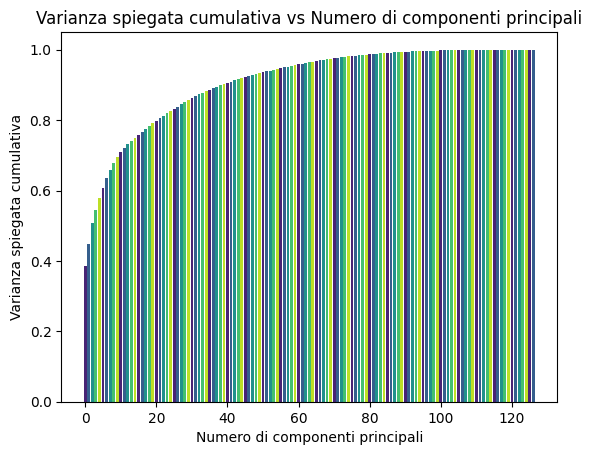

In [58]:
pca = PCA() 
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_val_reduced_pca = pca.transform(X_val_reduced)
X_test_reduced_pca = pca.transform(X_test_reduced)

# Stampa della varianza spiegata per ogni componente principale
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot della varianza spiegata cumulativa
plt.bar(range(len(cumulative_variance_ratio)), cumulative_variance_ratio, color=colors)
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Varianza spiegata cumulativa vs Numero di componenti principali')
plt.show()

In [59]:
# Usare solo le prime 45 componenti principali
pca = PCA(n_components=45)
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_val_reduced_pca = pca.transform(X_val_reduced)
X_test_reduced_pca = pca.transform(X_test_reduced)

explained_variance_45 = np.sum(pca.explained_variance_ratio_)
print(f"Varianza spiegata dalle prime 45 componenti: {explained_variance_45:.2f}")

Varianza spiegata dalle prime 45 componenti: 0.92


## Model fitting and validation con PCA
Dopo aver applicato la PCA per la riduzione della dimensionalità, i modelli vengono addestrati sui dati trasformati. Vengono utilizzati gli stessi modelli (Random Forest, Bagging, AdaBoost, SVC) per valutare se l'applicazione della PCA mantiene le performance simili a quelle ottenute senza PCA.

### Random Forest

In [60]:
classifier = RandomForestClassifier()

parameters = {'n_estimators' : [19,20,21,22,23],
    'criterion' : ['gini'],
             'max_depth' : [4,5,6,7,8,9,10], 
             'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [4,5,6],
              'class_weight': [class_weights]
             }

# Ricerca degli iperparametri e valutazione del modello sul dataset ridotto e trasformato con PCA (45 componenti principali)
best_model_RF_reduced_pca, best_param_RF_reduced_pca, f1_train_RF_reduced_pca, f1_val_RF_reduced_pca, accuracy_train_RF_reduced_pca, accuracy_val_RF_reduced_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced, X_val_reduced_pca, y_val_reduced)

----------------------------------------
Classificatore: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                     np.int64(1): np.float64(1.1053839364518976),
                                     np.int64(2): np.float64(0.7594906003638568),
                                     np.int64(3): np.float64(1.5217496962332928),
                                     np.int64(4): np.float64(6.626455026455027)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=23)
Migliori Parametri: {'n_estimators': 21, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Scor

### Bagging Tree Classifier

In [61]:
classifier = BaggingClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,5,6,7,8,9],
              'estimator':[base],
              'random_state':[2]}

# Ricerca degli iperparametri e valutazione del modello sul dataset ridotto e trasformato con PCA (45 componenti principali)classifier = BaggingClassifier()
best_model_BC_reduced_pca, best_param_BC_reduced_pca, f1_train_BC_reduced_pca, f1_val_BC_reduced_pca, accuracy_train_BC_reduced_pca, accuracy_val_BC_reduced_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced, X_val_reduced_pca, y_val_reduced)

----------------------------------------
Classificatore: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                 np.int64(1): np.float64(1.1053839364518976),
                                                                 np.int64(2): np.float64(0.7594906003638568),
                                                                 np.int64(3): np.float64(1.5217496962332928),
                                                                 np.int64(4): np.float64(6.626455026455027)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Migliori Parametri: {'n_estimators': 6, 'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),

### Adaboost Tree Classifier

In [62]:
classifier = AdaBoostClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,6,7,8,9,10,11],
              'estimator':[base], 
              'learning_rate' :[0.5,0.6,0.7,0.8,0.9,1],
              'random_state':[2],
              'algorithm':['SAMME']}

# Ricerca degli iperparametri e valutazione del modello sul dataset ridotto e trasformato con PCA (45 componenti principali)classifier = AdaBoostClassifier()
best_model_AB_reduced_pca, best_param_AB_reduced_pca, f1_train_AB_reduced_pca, f1_val_AB_reduced_pca, accuracy_train_AB_reduced_pca, accuracy_val_AB_reduced_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced, X_val_reduced_pca, y_val_reduced)

----------------------------------------
Classificatore: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074554294975688),
                                                                  np.int64(1): np.float64(1.1053839364518976),
                                                                  np.int64(2): np.float64(0.7594906003638568),
                                                                  np.int64(3): np.float64(1.5217496962332928),
                                                                  np.int64(4): np.float64(6.626455026455027)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=1, n_estimators=11, random_state=2)
Migliori Parametri: {'n_estimators': 10, 'estimator': DecisionTreeCla

### Support Vector Classifier

In [63]:
classifier = SVC()

parameters = {"kernel":['rbf'],
              "C":[0.01,0.1,1],
              "probability":[True],
              "class_weight":[class_weights]}

# Ricerca degli iperparametri e valutazione del modello sul dataset ridotto e trasformato con PCA (45 componenti principali)
best_model_SVC_reduced_pca, best_param_SVC_reduced_pca, f1_train_SVC_reduced_pca, f1_val_SVC_reduced_pca, accuracy_train_SVC_reduced_pca, accuracy_val_SVC_reduced_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced, X_val_reduced_pca, y_val_reduced)

----------------------------------------
Classificatore: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074554294975688),
                  np.int64(1): np.float64(1.1053839364518976),
                  np.int64(2): np.float64(0.7594906003638568),
                  np.int64(3): np.float64(1.5217496962332928),
                  np.int64(4): np.float64(6.626455026455027)},
    probability=True)
Migliori Parametri: {'kernel': 'rbf', 'C': 1, 'probability': True, 'class_weight': {np.int64(0): np.float64(0.5074554294975688), np.int64(1): np.float64(1.1053839364518976), np.int64(2): np.float64(0.7594906003638568), np.int64(3): np.float64(1.5217496962332928), np.int64(4): np.float64(6.626455026455027)}}
----------------------------------------
F1 Score (Train): 0.588
F1 Score (Validation): 0.445
Accuracy (Train): 0.586
Accuracy (Validation): 0.440
----------------------------------------


## Risultati model fitting e validation con PCA

I risultati ottenuti dai modelli con e senza PCA mostrano le seguenti differenze:

- **Overfitting**: Con l'uso di PCA, l'overfitting è stato ridotto. Questo perché la PCA riduce la dimensionalità dei dati, eliminando il rumore e le feature irrilevanti, favorendo una generalizzazione migliore. Al contrario, senza PCA, il modello tende a soffrire maggiormente di overfitting, specialmente quando ci sono molte feature non utili.
  
- **Performance su Training**: Le performance sui dati di training sono peggiorate leggermente con la PCA, poiché la riduzione delle feature ha limitato la capacità del modello di adattarsi perfettamente ai dati di addestramento. Senza PCA, il modello riesce ad adattarsi meglio ai dati di training, ma a rischio di overfitting.

- **Performance su Validation**: L'uso di PCA ha portato a un miglioramento delle performance sui dati di validazione e test. La riduzione della dimensionalità aiuta il modello a generalizzare meglio, riducendo l'overfitting e migliorando la capacità predittiva. Al contrario, senza PCA, le performance sui dati di validazione tendono a essere peggiori a causa dell'overfitting.


- **Tempo di computazione**: L'applicazione della PCA riduce il tempo di computazione, poiché il modello lavora su un numero inferiore di feature. Senza PCA, il tempo di allenamento e predizione aumenta a causa della maggiore complessità computazionale derivante dal numero più elevato di feature.

In generale, i risultati suggeriscono che l'uso della PCA contribuisce a una maggiore efficienza e stabilità del modello, migliorando la generalizzazione e riducendo il rischio di overfitting, anche se con una leggera perdita nelle performance sui dati di training.
Essendo tale perdita minima si è deciso di utilizzare come features finali per il metodo hold-out, le prime 45 Principal Components calcolate in precedenza

In [64]:
# Stampa dei risultati in un DataFrame per confrontare le performance del modello sul dataset ridotto e trasformato con PCA (45 componenti principali)
results_reduced_pca = pd.DataFrame({
    'Model': ['Random Forest PCA', 'Bagging PCA', 'AdaBoost PCA', 'SVC PCA'],
    'F1 Score (Train)': [f1_train_RF_reduced_pca, f1_train_BC_reduced_pca, f1_train_AB_reduced_pca, f1_train_SVC_reduced_pca],
    'F1 Score (Validation)': [f1_val_RF_reduced_pca, f1_val_BC_reduced_pca, f1_val_AB_reduced_pca, f1_val_SVC_reduced_pca],
    'Accuracy (Train)': [accuracy_train_RF_reduced_pca, accuracy_train_BC_reduced_pca, accuracy_train_AB_reduced_pca, accuracy_train_SVC_reduced_pca],
    'Accuracy (Validation)': [accuracy_val_RF_reduced_pca, accuracy_val_BC_reduced_pca, accuracy_val_AB_reduced_pca, accuracy_val_SVC_reduced_pca]
})

In [65]:
model_metrics = pd.concat([results_reduced, results_reduced_pca], axis=0)
model_metrics

,Model,F1 Score (Train),F1 Score (Validation),Accuracy (Train),Accuracy (Validation)
0,Random Forest,0.650984,0.427869,0.652986,0.433589
1,Bagging,0.476041,0.367868,0.480677,0.371009
2,AdaBoost,0.517564,0.409504,0.516768,0.404853
3,SVC,0.647544,0.456208,0.645161,0.450192
0,Random Forest PCA,0.645159,0.404137,0.646279,0.403576
1,Bagging PCA,0.467599,0.376344,0.467263,0.370370
2,AdaBoost PCA,0.553042,0.381915,0.551900,0.376117
3,SVC PCA,0.588196,0.444964,0.586075,0.439974


## Testing
Una volta applicata la PCA al dataset migliore, i modelli vengono testati per valutare le loro performance.
Il **test set** non è mai stato utilizzato durante il processo di training o validazione, rendendolo uno strumento fondamentale per una valutazione obiettiva della capacità di generalizzazione dei modelli. Questo approccio garantisce che i risultati riflettano il comportamento dei modelli su dati completamente nuovi, simulando scenari reali di applicazione.

Per ciascun modello testato sul dataset migliore con PCA, vengono presentati i seguenti risultati: 
- **Confusion Matrix**

- **Metriche di Valutazione**:
  - **F1 Score**
  - **Accuracy**


In [66]:
# Funzione per la creazione della confusion matrix (predicted sulle colonne, actual sulle righe)
def print_confusion_matrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    print(f'Confusion Matrix: {title}')
    print(cm)
    print('\n') 
    
# Stampa della confusion matrix per il modello Random Forest con PCA sul test set
print_confusion_matrix(best_model_RF_reduced_pca, X_test_reduced_pca, y_test_reduced, 'Random Forest PCA')

# Stampa della confusion matrix per il modello Bagging con PCA sul test set
print_confusion_matrix(best_model_BC_reduced_pca, X_test_reduced_pca, y_test_reduced, 'Bagging PCA')

# Stampa della confusion matrix per il modello AdaBoost con PCA sul test set
print_confusion_matrix(best_model_AB_reduced_pca, X_test_reduced_pca, y_test_reduced, 'AdaBoost PCA')

# Stampa della confusion matrix per il modello SVC con PCA sul test set
print_confusion_matrix(best_model_SVC_reduced_pca, X_test_reduced_pca, y_test_reduced, 'SVC PCA')

Confusion Matrix: Random Forest PCA
[[384 183 116  85   4]
 [147  77  77  48   5]
 [162  96 137 113   8]
 [ 44  22  59 106  26]
 [  1   1   5  28  24]]


Confusion Matrix: Bagging PCA
[[329 169 149 113  12]
 [101  91  92  67   3]
 [132 103 156 105  20]
 [ 32  39  49  98  39]
 [  1   1   1  28  28]]


Confusion Matrix: AdaBoost PCA
[[303 225 183  57   4]
 [124 105  90  34   1]
 [149 116 143  93  15]
 [ 40  38  62  91  26]
 [  2   2   6  28  21]]


Confusion Matrix: SVC PCA
[[410 204 122  34   2]
 [128 122  66  36   2]
 [132 104 179  95   6]
 [ 22  23  63 128  21]
 [  0   0   0  26  33]]




In [67]:
# Funzione per il test del modello
def test_model(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred, average='weighted')
    accuracy = metrics.accuracy_score(y, y_pred)
    return f1, accuracy

# Test del modello Random Forest con PCA sul test set
f1_test_RF_reduced_pca, accuracy_test_RF_reduced_pca = test_model(best_model_RF_reduced_pca, X_test_reduced_pca, y_test_reduced)

# Test del modello Bagging con PCA sul test set
f1_test_BC_reduced_pca, accuracy_test_BC_reduced_pca = test_model(best_model_BC_reduced_pca, X_test_reduced_pca, y_test_reduced)

# Test del modello AdaBoost con PCA sul test set
f1_test_AB_reduced_pca, accuracy_test_AB_reduced_pca = test_model(best_model_AB_reduced_pca, X_test_reduced_pca, y_test_reduced)

# Test del modello SVC con PCA sul test set
f1_test_SVC_reduced_pca, accuracy_test_SVC_reduced_pca = test_model(best_model_SVC_reduced_pca, X_test_reduced_pca, y_test_reduced)

# Dataframe con le metriche di test per i modelli
results_test = pd.DataFrame({
    'Model': ['Random Forest PCA', 'Bagging PCA', 'AdaBoost PCA', 'SVC PCA'],
    'F1 Score (Test)': [f1_test_RF_reduced_pca, f1_test_BC_reduced_pca, f1_test_AB_reduced_pca, f1_test_SVC_reduced_pca],
    'Accuracy (Test)': [accuracy_test_RF_reduced_pca, accuracy_test_BC_reduced_pca, accuracy_test_AB_reduced_pca, accuracy_test_SVC_reduced_pca]
})

results_test

,Model,F1 Score (Test),Accuracy (Test)
0,Random Forest PCA,0.373031,0.371808
1,Bagging PCA,0.367628,0.358529
2,AdaBoost PCA,0.345167,0.338611
3,SVC PCA,0.449740,0.445352


In [68]:
# Stampa delle shape di X_train, X_val e X_test ridotte e trasformate con PCA
print('Shape di X_train_reduced_pca:')
print(X_train_reduced_pca.shape)

print('Shape di X_val_reduced_pca:')
print(X_val_reduced_pca.shape)

print('Shape di X_test_reduced_pca:')
print(X_test_reduced_pca.shape)

Shape di X_train_reduced_pca:
(6262, 45)
Shape di X_val_reduced_pca:
(1566, 45)
Shape di X_test_reduced_pca:
(1958, 45)
